In [121]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import string
import xml.etree.ElementTree as ET
import re
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from transformers import BertPreTrainedModel
from torch.nn import BCEWithLogitsLoss


In [159]:
def xml_to_csv(file):
  tree = ET.parse(file)
  root = tree.getroot()

  # Create empty lists to store data
  texts = []
  categories = []
  polarities = []
  entities = []
  attributes = []
  text_list = []
  cat_lists = []
  # Loop through each sentence in the XML data
  for sentence in root.findall('./Review/sentences/sentence'):
      # Get the sentence text
      # text = re.findall(r"\w+(?:[-.']\w+)*|'\S\w*", (sentence.find('text').text))
      text = sentence.find('text').text     
      cat_list = []
      opinions = sentence.find("Opinions")
       
      # Loop through each opinion in the sentence
      for opinion in sentence.findall('Opinions/Opinion'):
          
          # Get the opinion target and polarity
          category = opinion.get('category')
          polarity = opinion.get('polarity')
          entity = category.split("#")[0]
          attribute = category.split("#")[1]
          # Append the data to the lists
          texts.append(text)
          categories.append(category)
          cat_list.append(category)
          polarities.append(polarity)
          entities.append(entity)
          attributes.append(attribute)
      if opinions is not None:
         text_list.append(text)
         cat_lists.append(cat_list)


  # Create a pandas DataFrame with the data
  df = pd.DataFrame({'Text': texts, 'Entity': entities, 'Attribute': attributes, 'Category': categories, 'Polarity': polarities})
  df_acd = pd.DataFrame({"Text": text_list, "Category": cat_lists})
  return (df,df_acd)

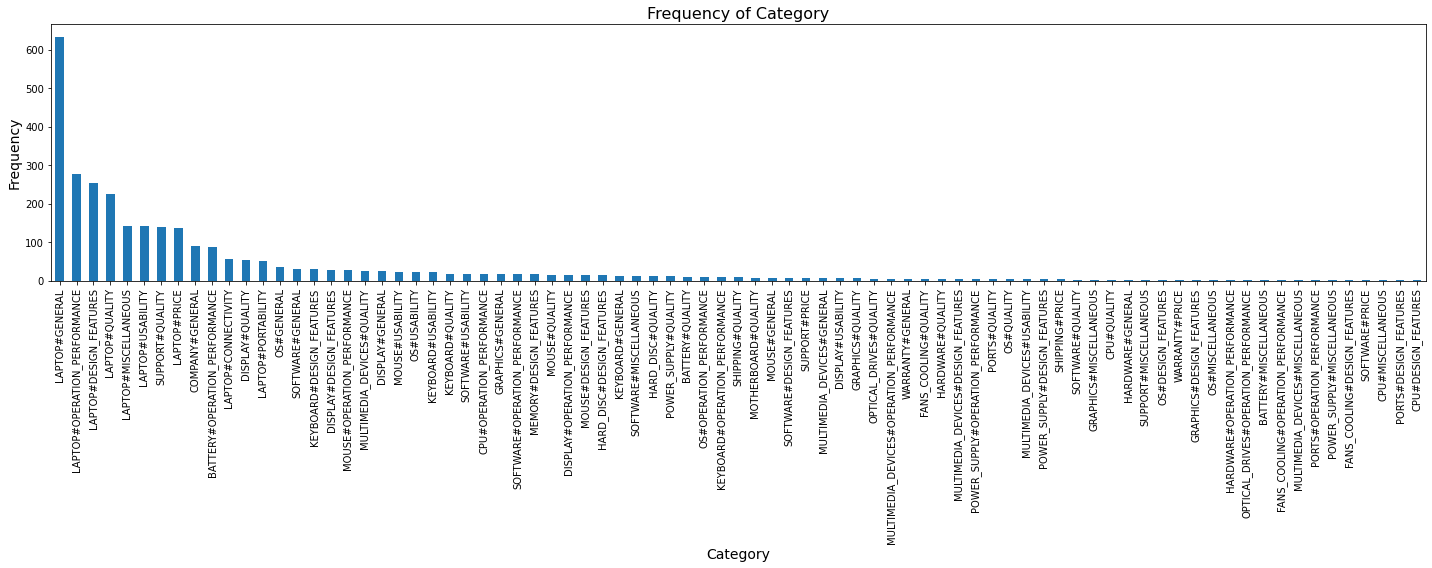

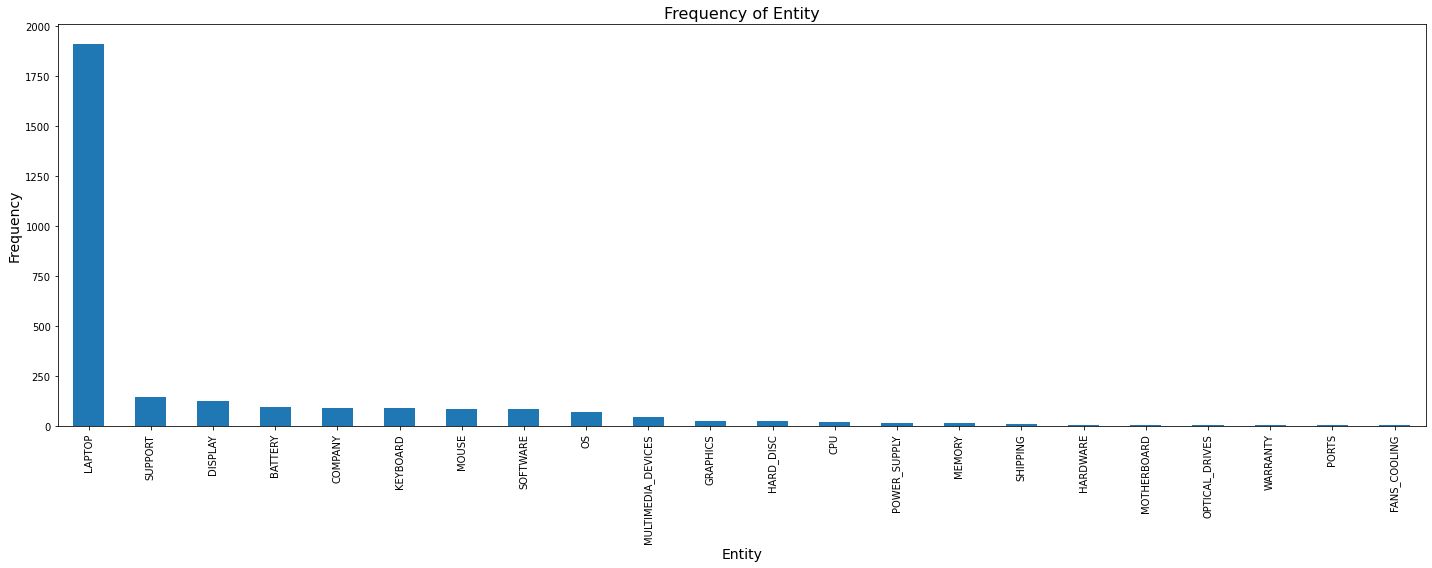

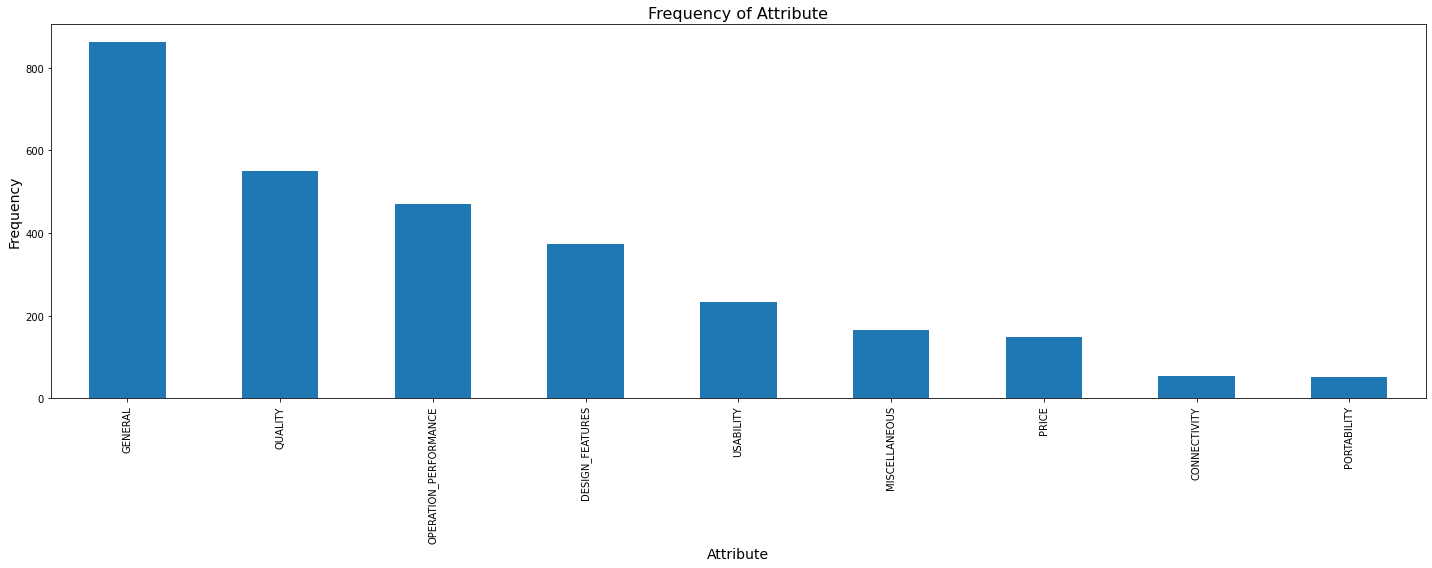

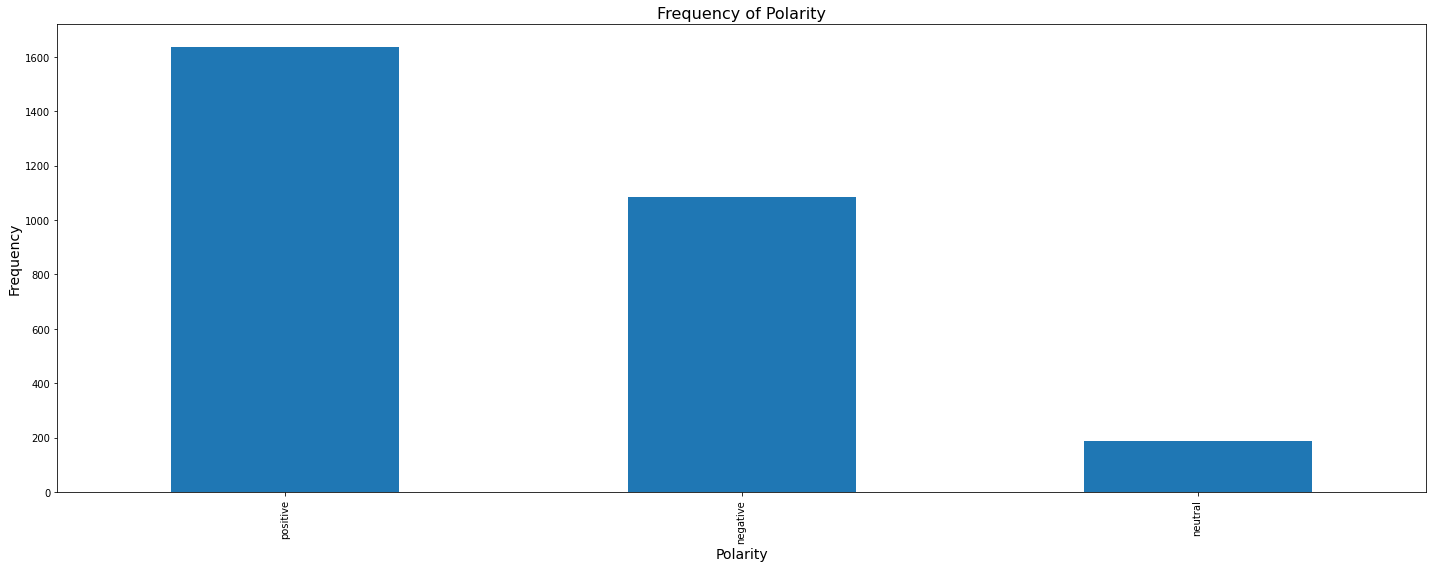

In [160]:
df,df_acd = xml_to_csv("Laptops_Train_p1.xml")
for i in ["Category","Entity", "Attribute","Polarity"]:    
    category_counts =df[i].value_counts()
    fig, ax = plt.subplots(figsize=(20, 8))
    category_counts.plot(kind='bar', ax=ax)

    # Set labels and title
    ax.set_xlabel(i, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title(f'Frequency of {i}', fontsize=16)

    # Rotate the x-axis labels for better readability without increasing font size
    plt.xticks(rotation=90)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [164]:
def xml_to_csv(file):
    tree = ET.parse(file)
    root = tree.getroot()

    # Define the entity labels
    entity_labels = [
        "LAPTOP", "DISPLAY", "KEYBOARD", "MOUSE", "MOTHERBOARD", "CPU", "FANS_COOLING",
        "PORTS", "MEMORY", "POWER_SUPPLY", "OPTICAL_DRIVES", "BATTERY", "GRAPHICS",
        "HARD_DISK", "MULTIMEDIA_DEVICES", "HARDWARE", "SOFTWARE", "OS", "WARRANTY",
        "SHIPPING", "SUPPORT", "COMPANY"
    ]

    # Extract sentences and opinions
    data = []
    for sentence in root.findall(".//sentence"):
        text = sentence.find("text").text
        opinions = sentence.findall('Opinions/Opinion')
        if opinions:
            for entity in entity_labels:
                for opinion in opinions:
                    category = opinion.get("category")
                    polarity = opinion.get("polarity")
                    if entity in category:
                        attribute = category.split("#")[1]
                        data.append([text, entity, attribute])
                        break
                else:
                    data.append([text, entity, "NONE"])

    # Create a pandas DataFrame
    df = pd.DataFrame(data, columns=["Text", "Entity", "Attribute"])
    df["SentencePair"] = "[CLS] " + df["Text"] + " [SEP] " + df["Entity"]   
    return df

In [165]:
df = xml_to_csv("Laptops_Train_p1.xml")
df.head(22)

,Text,Entity,Attribute,SentencePair
0,This computer is absolutely AMAZING!!!,LAPTOP,GENERAL,[CLS] This computer is absolutely AMAZING!!! [...
1,This computer is absolutely AMAZING!!!,DISPLAY,NONE,[CLS] This computer is absolutely AMAZING!!! [...
2,This computer is absolutely AMAZING!!!,KEYBOARD,NONE,[CLS] This computer is absolutely AMAZING!!! [...
3,This computer is absolutely AMAZING!!!,MOUSE,NONE,[CLS] This computer is absolutely AMAZING!!! [...
4,This computer is absolutely AMAZING!!!,MOTHERBOARD,NONE,[CLS] This computer is absolutely AMAZING!!! [...
5,This computer is absolutely AMAZING!!!,CPU,NONE,[CLS] This computer is absolutely AMAZING!!! [...
6,This computer is absolutely AMAZING!!!,FANS_COOLING,NONE,[CLS] This computer is absolutely AMAZING!!! [...
7,This computer is absolutely AMAZING!!!,PORTS,NONE,[CLS] This computer is absolutely AMAZING!!! [...
8,This computer is absolutely AMAZING!!!,MEMORY,NONE,[CLS] This computer is absolutely AMAZING!!! [...
9,This computer is absolutely AMAZING!!!,POWER_SUPPLY,NONE,[CLS] This computer is absolutely AMAZING!!! [...


In [ ]:
def attribute_to_label(attribute):
    attribute_labels = {
        "GENERAL": 0,
        "PRICE": 1,
        "QUALITY": 2,
        "DESIGN_FEATURES": 3,
        "OPERATION_PERFORMANCE": 4,
        "USABILITY": 5,
        "PORTABILITY": 6,
        "CONNECTIVITY": 7,
        "MISCELLANEOUS": 8,
        "NONE": 9
    }

In [114]:
# One-hot encode the categories
one_hot_encoded = pd.get_dummies(df_acd["Category"].apply(pd.Series).stack()).sum(level=0)

# Convert the one-hot encoded categories to a list of lists
labels = one_hot_encoded.values.tolist()
texts = df_acd["Text"]

/var/folders/c1/n6njh8610_v4ryk9tt7yh9nc0000gn/T/ipykernel_19443/2873282471.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  one_hot_encoded = pd.get_dummies(df_acd["Category"].apply(pd.Series).stack()).sum(level=0)


In [110]:
class ACD_Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [119]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
batch_size=16

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

max_length = 128  # Choose a suitable maximum sequence length

train_dataset = ACD_Dataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = ACD_Dataset(val_texts, val_labels, tokenizer, max_length)

In [120]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [122]:
class BERT_ACD(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertForSequenceClassification(config)
        self.loss = BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [ ]:
num_labels = len(one_hot_encoded.columns)
model = BERT_ACD.from_pretrained("bert-base-uncased", num_labels=num_labels)

In [130]:
print(df['Text']. nunique())
print(df['Category']. nunique())
print(df['Entity']. nunique())
print(df['Attribute']. nunique())

573
67
22
9


In [ ]:
percent_share = (df['Category'].value_counts() / df['Category'].count()) * 100

# Display the percentage share
print(percent_share)

In [ ]:
# E_0 = [CLS] + Sentence tokens + [SEP] + Entity => 0 for No Entity in the sentence, 1-9 for the 9 possible attributes
# E_0 = [CLS] + Sentence tokens + [SEP] + E#A => Sentiment
